In [1]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:

from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    train_loss = []
    train_counter = []
    model.train() #set to training mode

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.type(torch.LongTensor)
        targets = targets.view(-1).to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    test_counter = []
    model.eval() # we need to set the mode for our model

    test_loss = 0
    correct = 0
    test_stat = {}
    predlist = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.type(torch.LongTensor)
            targets = targets.view(-1).to(device)

            output = model(images)
            test_loss += loss_fn(output, targets).item() * 64
            pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
            correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
            predlist += (pred)
    test_loss /= len(test_loader.dataset)
    test_counter.append(len(train_loader.dataset)*epoch)

    test_stat['loss'] = test_loss
    test_stat['accuracy'] = 100.*correct/len(test_loader.dataset)
    test_stat['prediction'] = torch.Tensor(predlist)
    #print(f"Pred: {len(test_stat['prediction'])} Data: {len(test_loader.dataset)}")
    if(epoch % 5 == 0):
      print(f"Test result on epoch {epoch}: total sample: {test_counter}, Avg loss: {test_stat['loss']:.3f}, Acc: {test_stat['accuracy']}%")

    # ----------- <End Your code> ---------------
    # dictionary output should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load data from NPZ file
data = np.load('/content/drive/MyDrive/recycle_data_shuffled.npz')

X_train = data['x_train'][0:1000]
y_train = torch.from_numpy(data['y_train'][0:1000])
X_val = data['x_test'][0:1000]
y_val = torch.from_numpy(data['y_test'][0:1000])


pil_images_train = [Image.fromarray(image.astype('uint8')) for image in X_train]
pil_images_test = [Image.fromarray(image.astype('uint8')) for image in X_val]

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),  # Normalization
])

#extra trnadmform : ,  # Convert to tensor transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transformed_train = torch.stack([transform(image.convert("RGB")) for image in pil_images_train])
transformed_test = torch.stack([transform(image.convert("RGB")) for image in pil_images_test])

#transformed_train = torch.stack([transform(image) for image in X_train_tensor])
#transformed_test = torch.stack([transform(image) for image in X_test_tensor])

# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(transformed_train, y_train)
test_dataset = torch.utils.data.TensorDataset(transformed_test, y_val)


torch.Size([3, 224, 224])


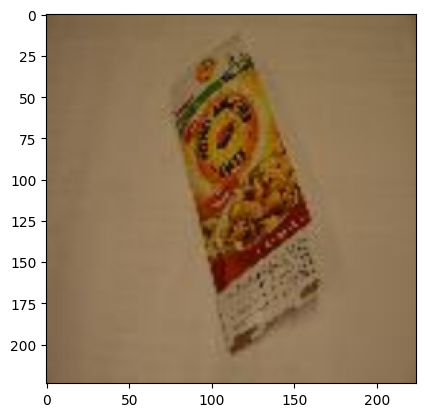

In [7]:
# Code to display images
batch_idx, (images, targets) = next(enumerate(train_dataset))
print(images.shape)
image = images.permute(1,2,0)
#image = image/2 + 0.5
plt.imshow(image)


In [8]:
batch_size_train, batch_size_test = 10, 100

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)


In [10]:
resnet50 = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')

i = 0
for param in resnet50.parameters():
    if(i> 4 and i < 55):
      param.requires_grad = False
    i += 1
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 5)
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
start = time.time()
max_epoch = 30

test_stat = {}
accuracies = []
losses = []
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001, betas=(0.5, 0.999))
for epoch in range(1, max_epoch+1):
  train(resnet50, criterion, optimizer, train_loader, epoch)
  teststat = test(resnet50, criterion, test_loader, epoch)
  accuracies.append(teststat['accuracy'].cpu())
  losses.append(teststat['loss'])

end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/1000] Loss: 1.5965321063995361
Epoch 2: [0/1000] Loss: 0.11377640813589096
Epoch 3: [0/1000] Loss: 0.5931277275085449
Epoch 4: [0/1000] Loss: 0.03986551612615585
Epoch 5: [0/1000] Loss: 0.025458013638854027
Test result on epoch 5: total sample: [5000], Avg loss: 0.189, Acc: 89.20000457763672%
Epoch 6: [0/1000] Loss: 0.03551071137189865
Epoch 7: [0/1000] Loss: 0.015094165690243244
Epoch 8: [0/1000] Loss: 0.032396938651800156
Epoch 9: [0/1000] Loss: 0.0072718337178230286
Epoch 10: [0/1000] Loss: 0.00564185157418251
Test result on epoch 10: total sample: [10000], Avg loss: 0.373, Acc: 81.70000457763672%
Epoch 11: [0/1000] Loss: 0.014945046976208687
Epoch 12: [0/1000] Loss: 0.006973120383918285
Epoch 13: [0/1000] Loss: 0.038857243955135345
Epoch 14: [0/1000] Loss: 0.013280550017952919
Epoch 15: [0/1000] Loss: 0.027065390720963478
Test result on epoch 15: total sample: [15000], Avg loss: 1.593, Acc: 64.60000610351562%
Epoch 16: [0/1000] Loss: 0.5933440923690796
Epoch 17: [0/1000

[tensor(68.5000), tensor(61.5000), tensor(85.8000), tensor(85.7000), tensor(89.2000), tensor(91.8000), tensor(91.4000), tensor(94.7000), tensor(92.0000), tensor(81.7000), tensor(94.3000), tensor(94.7000), tensor(97.7000), tensor(91.9000), tensor(64.6000), tensor(55.1000), tensor(93.6000), tensor(83.7000), tensor(45.8000), tensor(31.2000), tensor(97.9000), tensor(93.8000), tensor(93.0000), tensor(94.8000), tensor(95.8000), tensor(97.2000), tensor(97.0000), tensor(94.2000), tensor(95.3000), tensor(89.3000)]


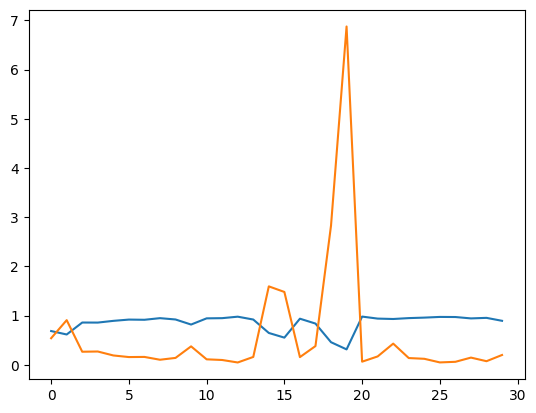

In [11]:
print(accuracies)
accuracies = [i/100 for i in accuracies]
plt.plot(accuracies)
plt.plot(losses)

In [13]:
print("Our model: \n\n", resnet50, '\n')
print("The state dict keys: \n\n", resnet50.state_dict().keys())

from google.colab import files

torch.save(resnet50.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

Our model: 

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>